# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.5133374675157323 -2.6909381116309703
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [26]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    rate = tf.placeholder(tf.float32, [], name='rate')
    return states, actions, targetQs, rewards, rate

In [27]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [28]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [29]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [30]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [40]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rewards, rate):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    Qs_labels = rewards[:-1] + (0.99 * targetQs[1:])
    #g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=rate * tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], shape=[-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [41]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [42]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rewards, self.rate = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, rewards=self.rewards, rate=self.rate) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [43]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [44]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [45]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [46]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            batch.append([state, action, Q_logits, reward])
            total_reward += reward
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        rewards = np.array([each[3] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.targetQs: targetQs.reshape([-1]),
                                                                       model.rewards: rewards, 
                                                                       model.rate: rate})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:11.0000 rate:0.0220 gloss:0.3409 dloss:1.2658 dlossR:0.5112 dlossQ:0.7545
Episode:1 meanR:10.5000 rate:0.0200 gloss:0.2893 dloss:1.2516 dlossR:0.4940 dlossQ:0.7576
Episode:2 meanR:10.3333 rate:0.0200 gloss:0.2439 dloss:1.2372 dlossR:0.4781 dlossQ:0.7591
Episode:3 meanR:10.0000 rate:0.0180 gloss:0.2123 dloss:1.2246 dlossR:0.4661 dlossQ:0.7585
Episode:4 meanR:9.8000 rate:0.0180 gloss:0.1701 dloss:1.2059 dlossR:0.4457 dlossQ:0.7602
Episode:5 meanR:9.8333 rate:0.0200 gloss:0.1222 dloss:1.1769 dlossR:0.4203 dlossQ:0.7566
Episode:6 meanR:9.7143 rate:0.0180 gloss:0.1103 dloss:1.1690 dlossR:0.4143 dlossQ:0.7547
Episode:7 meanR:9.7500 rate:0.0200 gloss:0.0479 dloss:1.1227 dlossR:0.3773 dlossQ:0.7454
Episode:8 meanR:9.6667 rate:0.0180 gloss:0.0362 dloss:1.1148 dlossR:0.3733 dlossQ:0.7416
Episode:9 meanR:9.7000 rate:0.0200 gloss:-0.0135 dloss:1.0677 dlossR:0.3433 dlossQ:0.7244
Episode:10 meanR:9.6364 rate:0.0180 gloss:-0.0437 dloss:1.0489 dlossR:0.3312 dlossQ:0.7176
Episode:11 mea

Episode:93 meanR:51.0426 rate:0.0860 gloss:0.0587 dloss:1.2634 dlossR:0.4548 dlossQ:0.8087
Episode:94 meanR:50.8316 rate:0.0620 gloss:0.0575 dloss:1.2421 dlossR:0.4321 dlossQ:0.8101
Episode:95 meanR:50.7396 rate:0.0840 gloss:0.0540 dloss:1.2597 dlossR:0.4513 dlossQ:0.8084
Episode:96 meanR:50.5979 rate:0.0740 gloss:0.0537 dloss:1.2530 dlossR:0.4441 dlossQ:0.8089
Episode:97 meanR:50.4184 rate:0.0660 gloss:0.0538 dloss:1.2472 dlossR:0.4383 dlossQ:0.8089
Episode:98 meanR:50.1717 rate:0.0520 gloss:0.0589 dloss:1.2353 dlossR:0.4266 dlossQ:0.8087
Episode:99 meanR:50.0200 rate:0.0700 gloss:0.0499 dloss:1.2489 dlossR:0.4397 dlossQ:0.8092
Episode:100 meanR:50.2500 rate:0.0680 gloss:0.0525 dloss:1.2477 dlossR:0.4392 dlossQ:0.8085
Episode:101 meanR:50.6100 rate:0.0920 gloss:0.0525 dloss:1.2696 dlossR:0.4626 dlossQ:0.8070
Episode:102 meanR:50.8600 rate:0.0700 gloss:0.0495 dloss:1.2482 dlossR:0.4396 dlossQ:0.8086
Episode:103 meanR:51.1200 rate:0.0700 gloss:0.0537 dloss:1.2496 dlossR:0.4413 dlossQ:0.

Episode:186 meanR:47.4200 rate:0.0700 gloss:0.0279 dloss:1.2633 dlossR:0.4615 dlossQ:0.8019
Episode:187 meanR:47.3300 rate:0.1060 gloss:0.0198 dloss:1.2933 dlossR:0.4943 dlossQ:0.7990
Episode:188 meanR:47.1000 rate:0.0700 gloss:0.0281 dloss:1.2596 dlossR:0.4564 dlossQ:0.8032
Episode:189 meanR:47.2600 rate:0.0980 gloss:0.0219 dloss:1.2812 dlossR:0.4803 dlossQ:0.8009
Episode:190 meanR:47.5400 rate:0.1520 gloss:0.0442 dloss:1.3244 dlossR:0.5281 dlossQ:0.7963
Episode:191 meanR:47.6300 rate:0.0820 gloss:0.0165 dloss:1.2683 dlossR:0.4660 dlossQ:0.8023
Episode:192 meanR:47.6700 rate:0.0840 gloss:0.0233 dloss:1.2724 dlossR:0.4711 dlossQ:0.8013
Episode:193 meanR:47.6400 rate:0.0800 gloss:0.0215 dloss:1.2657 dlossR:0.4631 dlossQ:0.8026
Episode:194 meanR:47.6600 rate:0.0660 gloss:0.0245 dloss:1.2517 dlossR:0.4472 dlossQ:0.8045
Episode:195 meanR:47.6700 rate:0.0860 gloss:0.0232 dloss:1.2692 dlossR:0.4658 dlossQ:0.8034
Episode:196 meanR:47.8500 rate:0.1100 gloss:0.0169 dloss:1.2911 dlossR:0.4898 dl

Episode:276 meanR:53.0500 rate:0.1980 gloss:0.0333 dloss:1.3584 dlossR:0.5747 dlossQ:0.7837
Episode:277 meanR:52.5800 rate:0.0640 gloss:0.0262 dloss:1.2634 dlossR:0.4659 dlossQ:0.7975
Episode:278 meanR:52.5800 rate:0.0760 gloss:0.0213 dloss:1.2778 dlossR:0.4846 dlossQ:0.7933
Episode:279 meanR:52.4200 rate:0.0780 gloss:0.0262 dloss:1.2852 dlossR:0.4937 dlossQ:0.7915
Episode:280 meanR:52.6700 rate:0.1220 gloss:0.0137 dloss:1.3162 dlossR:0.5284 dlossQ:0.7879
Episode:281 meanR:53.2000 rate:0.1860 gloss:0.0321 dloss:1.3542 dlossR:0.5744 dlossQ:0.7798
Episode:282 meanR:53.2000 rate:0.1340 gloss:0.0143 dloss:1.3239 dlossR:0.5388 dlossQ:0.7851
Episode:283 meanR:52.9800 rate:0.1260 gloss:0.0121 dloss:1.3168 dlossR:0.5298 dlossQ:0.7871
Episode:284 meanR:53.4800 rate:0.2000 gloss:0.0341 dloss:1.3629 dlossR:0.5874 dlossQ:0.7754
Episode:285 meanR:53.5200 rate:0.0980 gloss:0.0191 dloss:1.2972 dlossR:0.5076 dlossQ:0.7896
Episode:286 meanR:53.6600 rate:0.0980 gloss:0.0177 dloss:1.3009 dlossR:0.5136 dl

Episode:368 meanR:70.6500 rate:0.0780 gloss:0.0206 dloss:1.2965 dlossR:0.5088 dlossQ:0.7877
Episode:369 meanR:70.6100 rate:0.1040 gloss:0.0141 dloss:1.3068 dlossR:0.5154 dlossQ:0.7914
Episode:370 meanR:71.0700 rate:0.1740 gloss:0.0159 dloss:1.3574 dlossR:0.5853 dlossQ:0.7721
Episode:371 meanR:71.1200 rate:0.1120 gloss:0.0150 dloss:1.3096 dlossR:0.5128 dlossQ:0.7968
Episode:372 meanR:70.8700 rate:0.1120 gloss:0.0129 dloss:1.3077 dlossR:0.5076 dlossQ:0.8001
Episode:373 meanR:71.2700 rate:0.2820 gloss:0.0118 dloss:1.4008 dlossR:0.6256 dlossQ:0.7752
Episode:374 meanR:71.4000 rate:0.1080 gloss:0.0139 dloss:1.3099 dlossR:0.5146 dlossQ:0.7953
Episode:375 meanR:71.0600 rate:0.1100 gloss:0.0187 dloss:1.3136 dlossR:0.5249 dlossQ:0.7887
Episode:376 meanR:70.6100 rate:0.1080 gloss:0.0167 dloss:1.3118 dlossR:0.5256 dlossQ:0.7862
Episode:377 meanR:70.8300 rate:0.1080 gloss:0.0145 dloss:1.3180 dlossR:0.5378 dlossQ:0.7802
Episode:378 meanR:71.0500 rate:0.1200 gloss:0.0203 dloss:1.3259 dlossR:0.5459 dl

Episode:459 meanR:55.1000 rate:0.0940 gloss:0.0059 dloss:1.2733 dlossR:0.4700 dlossQ:0.8033
Episode:460 meanR:54.9500 rate:0.0600 gloss:0.0047 dloss:1.2389 dlossR:0.4338 dlossQ:0.8050
Episode:461 meanR:54.6700 rate:0.0900 gloss:0.0022 dloss:1.2753 dlossR:0.4704 dlossQ:0.8049
Episode:462 meanR:54.4400 rate:0.0940 gloss:0.0053 dloss:1.2744 dlossR:0.4697 dlossQ:0.8047
Episode:463 meanR:54.0400 rate:0.0620 gloss:0.0065 dloss:1.2323 dlossR:0.4232 dlossQ:0.8090
Episode:464 meanR:54.3000 rate:0.1460 gloss:0.0186 dloss:1.3162 dlossR:0.5154 dlossQ:0.8009
Episode:465 meanR:54.2400 rate:0.1080 gloss:0.0020 dloss:1.2786 dlossR:0.4721 dlossQ:0.8065
Episode:466 meanR:54.1400 rate:0.1100 gloss:0.0026 dloss:1.2914 dlossR:0.4901 dlossQ:0.8013
Episode:467 meanR:53.8200 rate:0.0940 gloss:0.0047 dloss:1.2758 dlossR:0.4728 dlossQ:0.8029
Episode:468 meanR:54.1900 rate:0.1520 gloss:0.0213 dloss:1.3281 dlossR:0.5354 dlossQ:0.7928
Episode:469 meanR:54.0000 rate:0.0660 gloss:0.0080 dloss:1.2586 dlossR:0.4578 dl

Episode:550 meanR:46.7000 rate:0.1340 gloss:0.0154 dloss:1.3176 dlossR:0.5260 dlossQ:0.7916
Episode:551 meanR:46.3300 rate:0.0940 gloss:0.0052 dloss:1.2795 dlossR:0.4802 dlossQ:0.7992
Episode:552 meanR:46.5200 rate:0.1320 gloss:0.0035 dloss:1.3155 dlossR:0.5228 dlossQ:0.7927
Episode:553 meanR:46.6600 rate:0.1040 gloss:0.0067 dloss:1.2948 dlossR:0.5004 dlossQ:0.7944
Episode:554 meanR:46.6600 rate:0.0660 gloss:0.0062 dloss:1.2586 dlossR:0.4577 dlossQ:0.8009
Episode:555 meanR:46.7700 rate:0.0960 gloss:0.0049 dloss:1.2927 dlossR:0.4993 dlossQ:0.7933
Episode:556 meanR:46.8700 rate:0.0820 gloss:0.0085 dloss:1.2762 dlossR:0.4783 dlossQ:0.7978
Episode:557 meanR:47.2000 rate:0.1280 gloss:0.0040 dloss:1.3103 dlossR:0.5154 dlossQ:0.7949
Episode:558 meanR:47.2000 rate:0.1340 gloss:0.0022 dloss:1.3124 dlossR:0.5168 dlossQ:0.7956
Episode:559 meanR:47.1900 rate:0.0920 gloss:0.0081 dloss:1.2801 dlossR:0.4806 dlossQ:0.7994
Episode:560 meanR:47.7700 rate:0.1760 gloss:0.0159 dloss:1.3451 dlossR:0.5565 dl

Episode:640 meanR:58.3000 rate:0.1000 gloss:0.0106 dloss:1.3037 dlossR:0.5171 dlossQ:0.7866
Episode:641 meanR:58.1000 rate:0.1040 gloss:0.0216 dloss:1.2997 dlossR:0.5074 dlossQ:0.7922
Episode:642 meanR:58.6300 rate:0.1800 gloss:0.0034 dloss:1.3470 dlossR:0.5601 dlossQ:0.7869
Episode:643 meanR:58.8900 rate:0.1580 gloss:0.0083 dloss:1.3316 dlossR:0.5404 dlossQ:0.7913
Episode:644 meanR:58.9900 rate:0.1060 gloss:0.0156 dloss:1.2997 dlossR:0.5073 dlossQ:0.7924
Episode:645 meanR:59.0300 rate:0.0980 gloss:0.0078 dloss:1.2940 dlossR:0.5004 dlossQ:0.7936
Episode:646 meanR:59.2300 rate:0.1340 gloss:0.0107 dloss:1.3225 dlossR:0.5360 dlossQ:0.7865
Episode:647 meanR:59.5300 rate:0.1680 gloss:0.0096 dloss:1.3429 dlossR:0.5597 dlossQ:0.7833
Episode:648 meanR:59.8800 rate:0.1480 gloss:0.0137 dloss:1.3328 dlossR:0.5499 dlossQ:0.7829
Episode:649 meanR:60.1400 rate:0.2100 gloss:0.0076 dloss:1.3673 dlossR:0.5949 dlossQ:0.7724
Episode:650 meanR:60.0200 rate:0.1100 gloss:0.0162 dloss:1.3198 dlossR:0.5419 dl

Episode:732 meanR:72.3800 rate:0.1300 gloss:0.0175 dloss:1.3314 dlossR:0.5553 dlossQ:0.7761
Episode:733 meanR:72.5500 rate:0.1280 gloss:0.0055 dloss:1.3288 dlossR:0.5504 dlossQ:0.7784
Episode:734 meanR:72.5200 rate:0.1060 gloss:0.0155 dloss:1.3139 dlossR:0.5298 dlossQ:0.7840
Episode:735 meanR:72.6200 rate:0.1160 gloss:0.0060 dloss:1.3090 dlossR:0.5176 dlossQ:0.7915
Episode:736 meanR:71.9300 rate:0.1000 gloss:0.0110 dloss:1.2888 dlossR:0.4908 dlossQ:0.7980
Episode:737 meanR:71.9900 rate:0.1480 gloss:0.0039 dloss:1.3211 dlossR:0.5228 dlossQ:0.7983
Episode:738 meanR:72.1000 rate:0.1500 gloss:0.0066 dloss:1.3184 dlossR:0.5142 dlossQ:0.8042
Episode:739 meanR:72.2900 rate:0.1500 gloss:0.0062 dloss:1.3216 dlossR:0.5226 dlossQ:0.7990
Episode:740 meanR:72.3500 rate:0.1120 gloss:0.0070 dloss:1.3013 dlossR:0.5049 dlossQ:0.7964
Episode:741 meanR:72.4000 rate:0.1140 gloss:0.0092 dloss:1.3067 dlossR:0.5147 dlossQ:0.7920
Episode:742 meanR:72.1500 rate:0.1300 gloss:0.0082 dloss:1.3218 dlossR:0.5353 dl

Episode:823 meanR:81.5700 rate:0.2260 gloss:0.0172 dloss:1.3831 dlossR:0.6583 dlossQ:0.7248
Episode:824 meanR:81.4400 rate:0.1300 gloss:0.0065 dloss:1.3417 dlossR:0.5763 dlossQ:0.7654
Episode:825 meanR:81.5700 rate:0.1320 gloss:0.0125 dloss:1.3405 dlossR:0.5699 dlossQ:0.7706
Episode:826 meanR:81.4700 rate:0.1160 gloss:0.0052 dloss:1.3231 dlossR:0.5404 dlossQ:0.7827
Episode:827 meanR:82.1300 rate:0.2480 gloss:0.0108 dloss:1.3854 dlossR:0.6261 dlossQ:0.7593
Episode:828 meanR:82.4200 rate:0.1680 gloss:0.0018 dloss:1.3412 dlossR:0.5516 dlossQ:0.7895
Episode:829 meanR:82.4100 rate:0.1240 gloss:0.0049 dloss:1.3137 dlossR:0.5204 dlossQ:0.7933
Episode:830 meanR:82.3700 rate:0.0880 gloss:0.0083 dloss:1.2922 dlossR:0.4986 dlossQ:0.7936
Episode:831 meanR:83.0900 rate:0.2680 gloss:0.0068 dloss:1.3951 dlossR:0.6111 dlossQ:0.7840
Episode:832 meanR:82.9000 rate:0.0920 gloss:0.0080 dloss:1.3041 dlossR:0.5191 dlossQ:0.7850
Episode:833 meanR:82.9400 rate:0.1360 gloss:0.0077 dloss:1.3354 dlossR:0.5599 dl

Episode:917 meanR:60.0800 rate:0.0840 gloss:0.0025 dloss:1.2579 dlossR:0.4500 dlossQ:0.8079
Episode:918 meanR:59.8600 rate:0.0800 gloss:0.0029 dloss:1.2536 dlossR:0.4452 dlossQ:0.8084
Episode:919 meanR:59.3200 rate:0.0900 gloss:0.0028 dloss:1.2613 dlossR:0.4544 dlossQ:0.8069
Episode:920 meanR:59.1300 rate:0.1500 gloss:0.0091 dloss:1.3235 dlossR:0.5270 dlossQ:0.7965
Episode:921 meanR:59.2700 rate:0.1460 gloss:0.0017 dloss:1.3219 dlossR:0.5265 dlossQ:0.7953
Episode:922 meanR:59.1400 rate:0.0860 gloss:0.0061 dloss:1.2788 dlossR:0.4809 dlossQ:0.7980
Episode:923 meanR:58.4000 rate:0.0780 gloss:0.0040 dloss:1.2771 dlossR:0.4807 dlossQ:0.7964
Episode:924 meanR:58.1300 rate:0.0760 gloss:0.0022 dloss:1.2697 dlossR:0.4700 dlossQ:0.7997
Episode:925 meanR:58.0300 rate:0.1120 gloss:0.0015 dloss:1.3041 dlossR:0.5102 dlossQ:0.7939
Episode:926 meanR:58.0800 rate:0.1260 gloss:0.0063 dloss:1.3160 dlossR:0.5236 dlossQ:0.7924
Episode:927 meanR:57.2400 rate:0.0800 gloss:0.0014 dloss:1.2748 dlossR:0.4759 dl

Episode:1008 meanR:48.9500 rate:0.0620 gloss:0.0024 dloss:1.2561 dlossR:0.4544 dlossQ:0.8017
Episode:1009 meanR:48.6400 rate:0.0620 gloss:0.0095 dloss:1.2582 dlossR:0.4570 dlossQ:0.8012
Episode:1010 meanR:48.6900 rate:0.1000 gloss:0.0032 dloss:1.2928 dlossR:0.4971 dlossQ:0.7957
Episode:1011 meanR:48.6200 rate:0.0880 gloss:0.0039 dloss:1.2777 dlossR:0.4779 dlossQ:0.7998
Episode:1012 meanR:48.6400 rate:0.0660 gloss:0.0005 dloss:1.2524 dlossR:0.4445 dlossQ:0.8079
Episode:1013 meanR:48.5900 rate:0.0700 gloss:0.0010 dloss:1.2563 dlossR:0.4484 dlossQ:0.8079
Episode:1014 meanR:48.8200 rate:0.1180 gloss:0.0042 dloss:1.2941 dlossR:0.4910 dlossQ:0.8031
Episode:1015 meanR:48.8400 rate:0.0960 gloss:0.0055 dloss:1.2797 dlossR:0.4783 dlossQ:0.8014
Episode:1016 meanR:48.7600 rate:0.0940 gloss:0.0015 dloss:1.2806 dlossR:0.4793 dlossQ:0.8013
Episode:1017 meanR:48.7100 rate:0.0740 gloss:0.0048 dloss:1.2638 dlossR:0.4620 dlossQ:0.8017
Episode:1018 meanR:48.8700 rate:0.1120 gloss:0.0008 dloss:1.2875 dloss

Episode:1097 meanR:60.2400 rate:0.1000 gloss:0.0144 dloss:1.3156 dlossR:0.5379 dlossQ:0.7777
Episode:1098 meanR:60.3000 rate:0.1300 gloss:0.0155 dloss:1.3271 dlossR:0.5480 dlossQ:0.7791
Episode:1099 meanR:60.7700 rate:0.1600 gloss:0.0105 dloss:1.3404 dlossR:0.5582 dlossQ:0.7822
Episode:1100 meanR:60.7100 rate:0.1060 gloss:0.0025 dloss:1.3004 dlossR:0.5077 dlossQ:0.7927
Episode:1101 meanR:61.1500 rate:0.1660 gloss:0.0038 dloss:1.3373 dlossR:0.5458 dlossQ:0.7915
Episode:1102 meanR:61.3900 rate:0.1220 gloss:0.0052 dloss:1.3073 dlossR:0.5120 dlossQ:0.7953
Episode:1103 meanR:61.7500 rate:0.1680 gloss:0.0103 dloss:1.3581 dlossR:0.5961 dlossQ:0.7620
Episode:1104 meanR:61.8800 rate:0.1020 gloss:0.0109 dloss:1.2983 dlossR:0.5056 dlossQ:0.7927
Episode:1105 meanR:62.1600 rate:0.1460 gloss:0.0053 dloss:1.3245 dlossR:0.5326 dlossQ:0.7920
Episode:1106 meanR:63.0400 rate:0.2480 gloss:0.0067 dloss:1.3834 dlossR:0.5969 dlossQ:0.7865
Episode:1107 meanR:62.9700 rate:0.2240 gloss:0.0078 dloss:1.3766 dloss

Episode:1186 meanR:73.2100 rate:0.2860 gloss:0.0063 dloss:1.3968 dlossR:0.6357 dlossQ:0.7612
Episode:1187 meanR:72.9800 rate:0.1140 gloss:0.0039 dloss:1.3325 dlossR:0.5651 dlossQ:0.7675
Episode:1188 meanR:73.5100 rate:0.2080 gloss:0.0051 dloss:1.3720 dlossR:0.6168 dlossQ:0.7552
Episode:1189 meanR:73.4400 rate:0.1260 gloss:0.0097 dloss:1.3428 dlossR:0.5811 dlossQ:0.7616
Episode:1190 meanR:73.6400 rate:0.1780 gloss:0.0121 dloss:1.3759 dlossR:0.6490 dlossQ:0.7269
Episode:1191 meanR:73.2700 rate:0.1120 gloss:0.0129 dloss:1.3218 dlossR:0.5421 dlossQ:0.7797
Episode:1192 meanR:74.0100 rate:0.3080 gloss:0.0043 dloss:1.4109 dlossR:0.6403 dlossQ:0.7706
Episode:1193 meanR:73.7800 rate:0.1040 gloss:0.0114 dloss:1.3163 dlossR:0.5349 dlossQ:0.7813
Episode:1194 meanR:73.5500 rate:0.1020 gloss:0.0083 dloss:1.3137 dlossR:0.5340 dlossQ:0.7797
Episode:1195 meanR:73.1500 rate:0.1140 gloss:0.0033 dloss:1.3224 dlossR:0.5445 dlossQ:0.7779
Episode:1196 meanR:73.9200 rate:0.3040 gloss:0.0073 dloss:1.4045 dloss

Episode:1276 meanR:73.0700 rate:0.1140 gloss:0.0026 dloss:1.2985 dlossR:0.4989 dlossQ:0.7996
Episode:1277 meanR:73.3500 rate:0.1600 gloss:0.0035 dloss:1.3337 dlossR:0.5397 dlossQ:0.7940
Episode:1278 meanR:73.4600 rate:0.1420 gloss:0.0041 dloss:1.3269 dlossR:0.5337 dlossQ:0.7932
Episode:1279 meanR:72.3800 rate:0.0820 gloss:0.0127 dloss:1.2884 dlossR:0.4942 dlossQ:0.7942
Episode:1280 meanR:72.5400 rate:0.1160 gloss:0.0029 dloss:1.3133 dlossR:0.5220 dlossQ:0.7913
Episode:1281 meanR:72.6500 rate:0.1600 gloss:0.0058 dloss:1.3439 dlossR:0.5671 dlossQ:0.7769
Episode:1282 meanR:72.4300 rate:0.2200 gloss:0.0044 dloss:1.3796 dlossR:0.6443 dlossQ:0.7354
Episode:1283 meanR:72.1000 rate:0.1380 gloss:0.0057 dloss:1.3411 dlossR:0.5702 dlossQ:0.7709
Episode:1284 meanR:72.2100 rate:0.1460 gloss:0.0093 dloss:1.3515 dlossR:0.5884 dlossQ:0.7631
Episode:1285 meanR:72.1600 rate:0.1360 gloss:0.0127 dloss:1.3409 dlossR:0.5734 dlossQ:0.7675
Episode:1286 meanR:71.2900 rate:0.1120 gloss:0.0115 dloss:1.3216 dloss

Episode:1366 meanR:69.7200 rate:0.1860 gloss:0.0094 dloss:1.3748 dlossR:0.6414 dlossQ:0.7334
Episode:1367 meanR:69.9100 rate:0.1720 gloss:0.0041 dloss:1.3481 dlossR:0.5699 dlossQ:0.7781
Episode:1368 meanR:69.9700 rate:0.1080 gloss:0.0040 dloss:1.3042 dlossR:0.5145 dlossQ:0.7897
Episode:1369 meanR:70.0900 rate:0.1180 gloss:0.0112 dloss:1.3143 dlossR:0.5291 dlossQ:0.7852
Episode:1370 meanR:70.2800 rate:0.1300 gloss:0.0062 dloss:1.3190 dlossR:0.5316 dlossQ:0.7874
Episode:1371 meanR:70.6500 rate:0.1740 gloss:0.0057 dloss:1.3466 dlossR:0.5643 dlossQ:0.7823
Episode:1372 meanR:70.7900 rate:0.1540 gloss:0.0042 dloss:1.3341 dlossR:0.5487 dlossQ:0.7854
Episode:1373 meanR:70.9800 rate:0.1720 gloss:0.0081 dloss:1.3670 dlossR:0.6233 dlossQ:0.7437
Episode:1374 meanR:71.4100 rate:0.1860 gloss:0.0027 dloss:1.3534 dlossR:0.5733 dlossQ:0.7801
Episode:1375 meanR:71.2400 rate:0.1740 gloss:0.0122 dloss:1.3461 dlossR:0.5633 dlossQ:0.7827
Episode:1376 meanR:71.8900 rate:0.2440 gloss:0.0045 dloss:1.3814 dloss

Episode:1457 meanR:77.7600 rate:0.1300 gloss:0.0044 dloss:1.3230 dlossR:0.5379 dlossQ:0.7852
Episode:1458 meanR:77.8500 rate:0.1240 gloss:0.0008 dloss:1.3149 dlossR:0.5259 dlossQ:0.7890
Episode:1459 meanR:77.4000 rate:0.0880 gloss:0.0067 dloss:1.2846 dlossR:0.4886 dlossQ:0.7960
Episode:1460 meanR:76.4600 rate:0.1200 gloss:0.0036 dloss:1.3051 dlossR:0.5093 dlossQ:0.7958
Episode:1461 meanR:76.1800 rate:0.1140 gloss:0.0042 dloss:1.3034 dlossR:0.5082 dlossQ:0.7952
Episode:1462 meanR:75.4000 rate:0.0920 gloss:0.0039 dloss:1.2867 dlossR:0.4907 dlossQ:0.7960
Episode:1463 meanR:75.8000 rate:0.1760 gloss:0.0041 dloss:1.3447 dlossR:0.5567 dlossQ:0.7880
Episode:1464 meanR:75.9100 rate:0.1400 gloss:0.0023 dloss:1.3250 dlossR:0.5368 dlossQ:0.7881
Episode:1465 meanR:76.1100 rate:0.1860 gloss:0.0114 dloss:1.3556 dlossR:0.5764 dlossQ:0.7791
Episode:1466 meanR:75.6000 rate:0.0840 gloss:0.0009 dloss:1.2888 dlossR:0.4973 dlossQ:0.7915
Episode:1467 meanR:75.3000 rate:0.1120 gloss:0.0061 dloss:1.3095 dloss

Episode:1546 meanR:62.6200 rate:0.1660 gloss:0.0014 dloss:1.3566 dlossR:0.5916 dlossQ:0.7651
Episode:1547 meanR:62.5300 rate:0.0980 gloss:0.0081 dloss:1.3135 dlossR:0.5298 dlossQ:0.7837
Episode:1548 meanR:62.5800 rate:0.0940 gloss:0.0002 dloss:1.3051 dlossR:0.5185 dlossQ:0.7866
Episode:1549 meanR:62.4900 rate:0.1340 gloss:0.0017 dloss:1.3271 dlossR:0.5452 dlossQ:0.7819
Episode:1550 meanR:62.7600 rate:0.1540 gloss:0.0043 dloss:1.3373 dlossR:0.5562 dlossQ:0.7811
Episode:1551 meanR:62.9200 rate:0.1700 gloss:0.0018 dloss:1.3460 dlossR:0.5653 dlossQ:0.7807
Episode:1552 meanR:63.1500 rate:0.2380 gloss:0.0059 dloss:1.3803 dlossR:0.6049 dlossQ:0.7754
Episode:1553 meanR:63.6700 rate:0.1920 gloss:0.0039 dloss:1.3620 dlossR:0.5854 dlossQ:0.7766
Episode:1554 meanR:63.7300 rate:0.1080 gloss:0.0043 dloss:1.3118 dlossR:0.5241 dlossQ:0.7878
Episode:1555 meanR:63.8800 rate:0.1480 gloss:0.0051 dloss:1.3318 dlossR:0.5466 dlossQ:0.7851
Episode:1556 meanR:63.7600 rate:0.1060 gloss:0.0088 dloss:1.3060 dloss

Episode:1637 meanR:86.9200 rate:0.3080 gloss:0.0053 dloss:1.4120 dlossR:0.6695 dlossQ:0.7425
Episode:1638 meanR:87.0800 rate:0.1480 gloss:0.0106 dloss:1.3788 dlossR:0.6526 dlossQ:0.7262
Episode:1639 meanR:86.9900 rate:0.1380 gloss:0.0140 dloss:1.3762 dlossR:0.6567 dlossQ:0.7195
Episode:1640 meanR:86.5000 rate:0.1400 gloss:0.0012 dloss:1.3745 dlossR:0.6525 dlossQ:0.7219
Episode:1641 meanR:87.7500 rate:0.3920 gloss:0.0112 dloss:1.3873 dlossR:0.6992 dlossQ:0.6881
Episode:1642 meanR:87.0300 rate:0.1380 gloss:0.0029 dloss:1.3638 dlossR:0.6242 dlossQ:0.7395
Episode:1643 meanR:86.9800 rate:0.1320 gloss:0.0045 dloss:1.3545 dlossR:0.6065 dlossQ:0.7479
Episode:1644 meanR:87.1400 rate:0.1220 gloss:0.0041 dloss:1.3345 dlossR:0.5669 dlossQ:0.7675
Episode:1645 meanR:87.3500 rate:0.1400 gloss:0.0055 dloss:1.3383 dlossR:0.5571 dlossQ:0.7812
Episode:1646 meanR:87.2000 rate:0.1360 gloss:0.0098 dloss:1.3340 dlossR:0.5431 dlossQ:0.7909
Episode:1647 meanR:87.4600 rate:0.1500 gloss:0.0027 dloss:1.3355 dloss

Episode:1725 meanR:110.0500 rate:0.2720 gloss:0.0112 dloss:1.3900 dlossR:0.6908 dlossQ:0.6992
Episode:1726 meanR:110.5200 rate:0.2560 gloss:0.0098 dloss:1.3971 dlossR:0.7011 dlossQ:0.6960
Episode:1727 meanR:110.9800 rate:0.1940 gloss:0.0085 dloss:1.4223 dlossR:0.7461 dlossQ:0.6762
Episode:1728 meanR:110.7700 rate:0.2420 gloss:0.0087 dloss:1.3917 dlossR:0.6897 dlossQ:0.7020
Episode:1729 meanR:112.5000 rate:0.5040 gloss:0.0066 dloss:1.4067 dlossR:0.6944 dlossQ:0.7123
Episode:1730 meanR:111.5500 rate:0.2260 gloss:0.0045 dloss:1.3851 dlossR:0.6788 dlossQ:0.7063
Episode:1731 meanR:110.8400 rate:0.1900 gloss:0.0125 dloss:1.3851 dlossR:0.6763 dlossQ:0.7088
Episode:1732 meanR:111.0900 rate:0.1860 gloss:0.0025 dloss:1.3843 dlossR:0.6728 dlossQ:0.7115
Episode:1733 meanR:111.4100 rate:0.3360 gloss:0.0107 dloss:1.3991 dlossR:0.6795 dlossQ:0.7196
Episode:1734 meanR:111.3100 rate:0.1600 gloss:0.0072 dloss:1.3817 dlossR:0.6765 dlossQ:0.7052
Episode:1735 meanR:111.0200 rate:0.1700 gloss:0.0126 dloss:1

Episode:1813 meanR:108.6000 rate:0.1400 gloss:0.0010 dloss:1.3513 dlossR:0.5969 dlossQ:0.7545
Episode:1814 meanR:107.5200 rate:0.1900 gloss:0.0016 dloss:1.3730 dlossR:0.6264 dlossQ:0.7466
Episode:1815 meanR:106.6800 rate:0.2060 gloss:0.0027 dloss:1.3743 dlossR:0.6022 dlossQ:0.7722
Episode:1816 meanR:106.5500 rate:0.1780 gloss:0.0035 dloss:1.3628 dlossR:0.5960 dlossQ:0.7669
Episode:1817 meanR:106.3000 rate:0.3460 gloss:0.0047 dloss:1.4193 dlossR:0.6574 dlossQ:0.7619
Episode:1818 meanR:106.5500 rate:0.3180 gloss:0.0107 dloss:1.4008 dlossR:0.6570 dlossQ:0.7438
Episode:1819 meanR:106.4700 rate:0.1580 gloss:0.0072 dloss:1.3775 dlossR:0.6463 dlossQ:0.7312
Episode:1820 meanR:106.6000 rate:0.2120 gloss:0.0031 dloss:1.3952 dlossR:0.6741 dlossQ:0.7210
Episode:1821 meanR:104.8400 rate:0.1520 gloss:0.0031 dloss:1.3908 dlossR:0.6734 dlossQ:0.7174
Episode:1822 meanR:104.3900 rate:0.1520 gloss:0.0051 dloss:1.3808 dlossR:0.6633 dlossQ:0.7175
Episode:1823 meanR:104.4500 rate:0.2420 gloss:0.0050 dloss:1

Episode:1901 meanR:112.5100 rate:0.3100 gloss:0.0213 dloss:1.3958 dlossR:0.6737 dlossQ:0.7221
Episode:1902 meanR:113.6900 rate:0.3840 gloss:0.0237 dloss:1.3979 dlossR:0.6881 dlossQ:0.7098
Episode:1903 meanR:113.9500 rate:0.2140 gloss:0.0113 dloss:1.3856 dlossR:0.6772 dlossQ:0.7084
Episode:1904 meanR:115.3400 rate:0.4580 gloss:0.0135 dloss:1.3796 dlossR:0.6980 dlossQ:0.6816
Episode:1905 meanR:115.1000 rate:0.1960 gloss:0.0102 dloss:1.3861 dlossR:0.6846 dlossQ:0.7015
Episode:1906 meanR:116.3200 rate:0.3840 gloss:0.0053 dloss:1.3899 dlossR:0.6941 dlossQ:0.6958
Episode:1907 meanR:116.6300 rate:0.2440 gloss:0.0071 dloss:1.3898 dlossR:0.7015 dlossQ:0.6883
Episode:1908 meanR:117.2200 rate:0.3320 gloss:0.0062 dloss:1.3836 dlossR:0.7193 dlossQ:0.6643
Episode:1909 meanR:118.7900 rate:0.4560 gloss:0.0129 dloss:1.3682 dlossR:0.7040 dlossQ:0.6642
Episode:1910 meanR:118.4700 rate:0.2580 gloss:0.0039 dloss:1.3932 dlossR:0.7168 dlossQ:0.6764
Episode:1911 meanR:119.2800 rate:0.2880 gloss:0.0078 dloss:1

Episode:1991 meanR:137.4300 rate:0.1740 gloss:0.0027 dloss:1.3884 dlossR:0.6586 dlossQ:0.7298
Episode:1992 meanR:137.5700 rate:0.1580 gloss:0.0072 dloss:1.3787 dlossR:0.6386 dlossQ:0.7401
Episode:1993 meanR:137.0900 rate:0.1660 gloss:0.0060 dloss:1.3724 dlossR:0.6289 dlossQ:0.7435
Episode:1994 meanR:136.9100 rate:0.1400 gloss:0.0032 dloss:1.3613 dlossR:0.6195 dlossQ:0.7418
Episode:1995 meanR:136.2600 rate:0.2080 gloss:0.0004 dloss:1.3792 dlossR:0.6484 dlossQ:0.7308
Episode:1996 meanR:136.9800 rate:0.3220 gloss:0.0027 dloss:1.4053 dlossR:0.6597 dlossQ:0.7456
Episode:1997 meanR:138.3900 rate:0.4760 gloss:0.0060 dloss:1.4391 dlossR:0.6962 dlossQ:0.7429
Episode:1998 meanR:137.3900 rate:0.1460 gloss:0.0049 dloss:1.3809 dlossR:0.6310 dlossQ:0.7500
Episode:1999 meanR:138.7500 rate:0.5220 gloss:0.0058 dloss:1.4254 dlossR:0.7027 dlossQ:0.7227
Episode:2000 meanR:138.7400 rate:0.1540 gloss:0.0008 dloss:1.3972 dlossR:0.6580 dlossQ:0.7392
Episode:2001 meanR:138.0800 rate:0.1780 gloss:0.0104 dloss:1

Episode:2079 meanR:103.9100 rate:0.1400 gloss:0.0010 dloss:1.3524 dlossR:0.5944 dlossQ:0.7580
Episode:2080 meanR:103.2200 rate:0.1000 gloss:0.0085 dloss:1.3370 dlossR:0.5758 dlossQ:0.7613
Episode:2081 meanR:103.0200 rate:0.1060 gloss:0.0013 dloss:1.3388 dlossR:0.5804 dlossQ:0.7585
Episode:2082 meanR:102.7300 rate:0.1640 gloss:0.0017 dloss:1.3598 dlossR:0.6080 dlossQ:0.7519
Episode:2083 meanR:100.4900 rate:0.1180 gloss:0.0012 dloss:1.3403 dlossR:0.5800 dlossQ:0.7603
Episode:2084 meanR:99.0000 rate:0.1420 gloss:0.0100 dloss:1.3497 dlossR:0.5913 dlossQ:0.7585
Episode:2085 meanR:99.4500 rate:0.2480 gloss:0.0023 dloss:1.3845 dlossR:0.6324 dlossQ:0.7522
Episode:2086 meanR:99.2500 rate:0.1480 gloss:0.0004 dloss:1.3507 dlossR:0.5897 dlossQ:0.7610
Episode:2087 meanR:98.8800 rate:0.1260 gloss:0.0036 dloss:1.3402 dlossR:0.5759 dlossQ:0.7643
Episode:2088 meanR:98.8500 rate:0.1220 gloss:0.0008 dloss:1.3390 dlossR:0.5753 dlossQ:0.7637
Episode:2089 meanR:98.4900 rate:0.1260 gloss:0.0006 dloss:1.3391 

Episode:2169 meanR:71.0500 rate:0.1020 gloss:0.0068 dloss:1.3076 dlossR:0.5204 dlossQ:0.7872
Episode:2170 meanR:70.5400 rate:0.0940 gloss:0.0011 dloss:1.2937 dlossR:0.4999 dlossQ:0.7938
Episode:2171 meanR:70.3500 rate:0.1020 gloss:0.0042 dloss:1.3030 dlossR:0.5130 dlossQ:0.7900
Episode:2172 meanR:69.7700 rate:0.0920 gloss:0.0007 dloss:1.2927 dlossR:0.5003 dlossQ:0.7924
Episode:2173 meanR:69.9500 rate:0.1880 gloss:0.0015 dloss:1.3535 dlossR:0.5691 dlossQ:0.7844
Episode:2174 meanR:69.8500 rate:0.0840 gloss:0.0024 dloss:1.2785 dlossR:0.4802 dlossQ:0.7983
Episode:2175 meanR:69.6300 rate:0.1060 gloss:0.0042 dloss:1.3045 dlossR:0.5120 dlossQ:0.7925
Episode:2176 meanR:69.1000 rate:0.0900 gloss:0.0045 dloss:1.2890 dlossR:0.4934 dlossQ:0.7957
Episode:2177 meanR:68.8700 rate:0.1220 gloss:0.0014 dloss:1.3119 dlossR:0.5189 dlossQ:0.7931
Episode:2178 meanR:68.9400 rate:0.1620 gloss:0.0032 dloss:1.3360 dlossR:0.5437 dlossQ:0.7923
Episode:2179 meanR:68.9900 rate:0.1500 gloss:0.0007 dloss:1.3322 dloss

Episode:2258 meanR:65.4200 rate:0.0960 gloss:0.0004 dloss:1.2917 dlossR:0.4968 dlossQ:0.7948
Episode:2259 meanR:64.8600 rate:0.0980 gloss:0.0005 dloss:1.3019 dlossR:0.5134 dlossQ:0.7885
Episode:2260 meanR:64.9700 rate:0.1120 gloss:0.0006 dloss:1.3037 dlossR:0.5116 dlossQ:0.7921
Episode:2261 meanR:64.8800 rate:0.0880 gloss:0.0003 dloss:1.2912 dlossR:0.5003 dlossQ:0.7908
Episode:2262 meanR:64.8200 rate:0.1080 gloss:0.0004 dloss:1.3035 dlossR:0.5131 dlossQ:0.7904
Episode:2263 meanR:64.3700 rate:0.0800 gloss:0.0000 dloss:1.2812 dlossR:0.4869 dlossQ:0.7943
Episode:2264 meanR:63.8300 rate:0.0980 gloss:0.0012 dloss:1.2981 dlossR:0.5074 dlossQ:0.7907
Episode:2265 meanR:63.7200 rate:0.0860 gloss:0.0011 dloss:1.2816 dlossR:0.4841 dlossQ:0.7975
Episode:2266 meanR:63.6000 rate:0.0860 gloss:0.0019 dloss:1.2788 dlossR:0.4797 dlossQ:0.7991
Episode:2267 meanR:63.6100 rate:0.0900 gloss:0.0001 dloss:1.2804 dlossR:0.4791 dlossQ:0.8013
Episode:2268 meanR:63.7100 rate:0.1160 gloss:0.0005 dloss:1.3001 dloss

Episode:2350 meanR:59.0300 rate:0.0880 gloss:0.0031 dloss:1.2749 dlossR:0.4738 dlossQ:0.8012
Episode:2351 meanR:58.9000 rate:0.0880 gloss:0.0056 dloss:1.2755 dlossR:0.4735 dlossQ:0.8020
Episode:2352 meanR:59.0300 rate:0.1400 gloss:0.0005 dloss:1.3164 dlossR:0.5175 dlossQ:0.7989
Episode:2353 meanR:59.6200 rate:0.2180 gloss:0.0029 dloss:1.3697 dlossR:0.5788 dlossQ:0.7909
Episode:2354 meanR:59.4900 rate:0.0900 gloss:0.0003 dloss:1.2831 dlossR:0.4857 dlossQ:0.7973
Episode:2355 meanR:59.4700 rate:0.1460 gloss:0.0001 dloss:1.3293 dlossR:0.5421 dlossQ:0.7872
Episode:2356 meanR:59.4800 rate:0.1040 gloss:0.0036 dloss:1.3026 dlossR:0.5115 dlossQ:0.7911
Episode:2357 meanR:59.5300 rate:0.1200 gloss:0.0018 dloss:1.3156 dlossR:0.5271 dlossQ:0.7885
Episode:2358 meanR:59.6400 rate:0.1180 gloss:0.0036 dloss:1.3147 dlossR:0.5262 dlossQ:0.7884
Episode:2359 meanR:60.1900 rate:0.2080 gloss:0.0037 dloss:1.3666 dlossR:0.5904 dlossQ:0.7762
Episode:2360 meanR:60.2000 rate:0.1140 gloss:0.0023 dloss:1.3080 dloss

Episode:2441 meanR:63.3600 rate:0.1440 gloss:0.0040 dloss:1.3264 dlossR:0.5368 dlossQ:0.7896
Episode:2442 meanR:63.8000 rate:0.1880 gloss:0.0017 dloss:1.3541 dlossR:0.5692 dlossQ:0.7849
Episode:2443 meanR:63.7900 rate:0.1020 gloss:0.0070 dloss:1.2966 dlossR:0.5030 dlossQ:0.7937
Episode:2444 meanR:63.6700 rate:0.1140 gloss:0.0047 dloss:1.3090 dlossR:0.5208 dlossQ:0.7882
Episode:2445 meanR:63.6200 rate:0.1100 gloss:0.0043 dloss:1.3071 dlossR:0.5186 dlossQ:0.7885
Episode:2446 meanR:63.5800 rate:0.1160 gloss:0.0006 dloss:1.3132 dlossR:0.5268 dlossQ:0.7864
Episode:2447 meanR:63.6400 rate:0.0960 gloss:0.0014 dloss:1.2944 dlossR:0.5024 dlossQ:0.7920
Episode:2448 meanR:63.4700 rate:0.1000 gloss:0.0062 dloss:1.2988 dlossR:0.5081 dlossQ:0.7907
Episode:2449 meanR:64.1300 rate:0.2200 gloss:0.0083 dloss:1.3725 dlossR:0.6033 dlossQ:0.7692
Episode:2450 meanR:64.2600 rate:0.1140 gloss:0.0004 dloss:1.3094 dlossR:0.5206 dlossQ:0.7888
Episode:2451 meanR:65.1800 rate:0.2720 gloss:0.0045 dloss:1.3945 dloss

Episode:2531 meanR:79.3100 rate:0.1960 gloss:0.0006 dloss:1.3636 dlossR:0.5980 dlossQ:0.7657
Episode:2532 meanR:79.4300 rate:0.1780 gloss:0.0007 dloss:1.3542 dlossR:0.5847 dlossQ:0.7695
Episode:2533 meanR:80.1700 rate:0.3860 gloss:0.0045 dloss:1.4301 dlossR:0.6703 dlossQ:0.7598
Episode:2534 meanR:80.6100 rate:0.1980 gloss:0.0049 dloss:1.3696 dlossR:0.6104 dlossQ:0.7592
Episode:2535 meanR:81.0200 rate:0.1940 gloss:0.0090 dloss:1.3754 dlossR:0.6243 dlossQ:0.7510
Episode:2536 meanR:81.5100 rate:0.2240 gloss:0.0051 dloss:1.3831 dlossR:0.6382 dlossQ:0.7449
Episode:2537 meanR:82.0800 rate:0.1980 gloss:0.0018 dloss:1.3768 dlossR:0.6306 dlossQ:0.7462
Episode:2538 meanR:82.3300 rate:0.1600 gloss:0.0185 dloss:1.3645 dlossR:0.6189 dlossQ:0.7456
Episode:2539 meanR:82.3800 rate:0.1500 gloss:0.0031 dloss:1.3568 dlossR:0.6062 dlossQ:0.7506
Episode:2540 meanR:83.9700 rate:0.4100 gloss:0.0118 dloss:1.4239 dlossR:0.6811 dlossQ:0.7427
Episode:2541 meanR:84.2600 rate:0.2020 gloss:0.0011 dloss:1.3731 dloss

Episode:2619 meanR:113.8200 rate:0.4340 gloss:0.0051 dloss:1.4369 dlossR:0.6874 dlossQ:0.7495
Episode:2620 meanR:114.3100 rate:0.2240 gloss:0.0009 dloss:1.3799 dlossR:0.6485 dlossQ:0.7314
Episode:2621 meanR:114.7300 rate:0.1960 gloss:0.0007 dloss:1.3902 dlossR:0.6981 dlossQ:0.6921
Episode:2622 meanR:114.2400 rate:0.2060 gloss:0.0002 dloss:1.3889 dlossR:0.6740 dlossQ:0.7148
Episode:2623 meanR:114.7200 rate:0.2100 gloss:0.0022 dloss:1.3888 dlossR:0.6719 dlossQ:0.7169
Episode:2624 meanR:114.8600 rate:0.1560 gloss:0.0016 dloss:1.3806 dlossR:0.6600 dlossQ:0.7205
Episode:2625 meanR:115.1400 rate:0.1940 gloss:0.0067 dloss:1.3769 dlossR:0.6515 dlossQ:0.7254
Episode:2626 meanR:115.0800 rate:0.1860 gloss:0.0038 dloss:1.3794 dlossR:0.6621 dlossQ:0.7173
Episode:2627 meanR:115.1100 rate:0.1740 gloss:0.0019 dloss:1.3664 dlossR:0.6166 dlossQ:0.7498
Episode:2628 meanR:114.9600 rate:0.1640 gloss:0.0041 dloss:1.3633 dlossR:0.5998 dlossQ:0.7634
Episode:2629 meanR:115.3500 rate:0.2140 gloss:0.0074 dloss:1

Episode:2707 meanR:114.7200 rate:0.1860 gloss:0.0039 dloss:1.3744 dlossR:0.6448 dlossQ:0.7296
Episode:2708 meanR:113.6000 rate:0.1980 gloss:0.0015 dloss:1.3767 dlossR:0.6498 dlossQ:0.7269
Episode:2709 meanR:113.9800 rate:0.2460 gloss:0.0030 dloss:1.3841 dlossR:0.6495 dlossQ:0.7347
Episode:2710 meanR:113.4000 rate:0.2300 gloss:0.0028 dloss:1.3811 dlossR:0.6446 dlossQ:0.7365
Episode:2711 meanR:113.1600 rate:0.1560 gloss:0.0106 dloss:1.3658 dlossR:0.6283 dlossQ:0.7375
Episode:2712 meanR:113.5100 rate:0.2860 gloss:0.0041 dloss:1.3917 dlossR:0.6576 dlossQ:0.7340
Episode:2713 meanR:113.0400 rate:0.1440 gloss:0.0025 dloss:1.3628 dlossR:0.6244 dlossQ:0.7383
Episode:2714 meanR:113.2300 rate:0.1620 gloss:0.0040 dloss:1.3642 dlossR:0.6217 dlossQ:0.7425
Episode:2715 meanR:112.8500 rate:0.1400 gloss:0.0007 dloss:1.3580 dlossR:0.6141 dlossQ:0.7439
Episode:2716 meanR:112.4500 rate:0.1660 gloss:0.0017 dloss:1.3635 dlossR:0.6142 dlossQ:0.7493
Episode:2717 meanR:112.4500 rate:0.1580 gloss:0.0003 dloss:1

Episode:2796 meanR:85.3900 rate:0.1400 gloss:0.0001 dloss:1.3360 dlossR:0.5605 dlossQ:0.7755
Episode:2797 meanR:84.6600 rate:0.1740 gloss:0.0038 dloss:1.3550 dlossR:0.5852 dlossQ:0.7697
Episode:2798 meanR:84.5400 rate:0.1480 gloss:0.0100 dloss:1.3446 dlossR:0.5748 dlossQ:0.7698
Episode:2799 meanR:84.3100 rate:0.1560 gloss:0.0062 dloss:1.3475 dlossR:0.5770 dlossQ:0.7706
Episode:2800 meanR:84.2000 rate:0.1440 gloss:0.0069 dloss:1.3438 dlossR:0.5750 dlossQ:0.7688
Episode:2801 meanR:84.1100 rate:0.1680 gloss:0.0013 dloss:1.3502 dlossR:0.5783 dlossQ:0.7720
Episode:2802 meanR:84.1600 rate:0.2180 gloss:0.0059 dloss:1.3795 dlossR:0.6440 dlossQ:0.7355
Episode:2803 meanR:84.1000 rate:0.1120 gloss:0.0000 dloss:1.3220 dlossR:0.5442 dlossQ:0.7778
Episode:2804 meanR:83.4000 rate:0.1640 gloss:0.0001 dloss:1.3473 dlossR:0.5706 dlossQ:0.7767
Episode:2805 meanR:83.4600 rate:0.1620 gloss:0.0014 dloss:1.3472 dlossR:0.5709 dlossQ:0.7763
Episode:2806 meanR:83.4900 rate:0.2000 gloss:0.0047 dloss:1.3648 dloss

Episode:2885 meanR:94.3900 rate:0.3820 gloss:0.0075 dloss:1.4188 dlossR:0.6716 dlossQ:0.7472
Episode:2886 meanR:95.0800 rate:0.2700 gloss:0.0018 dloss:1.3897 dlossR:0.6549 dlossQ:0.7348
Episode:2887 meanR:95.4600 rate:0.1960 gloss:0.0069 dloss:1.3809 dlossR:0.6511 dlossQ:0.7298
Episode:2888 meanR:95.8800 rate:0.1960 gloss:0.0011 dloss:1.3855 dlossR:0.6610 dlossQ:0.7245
Episode:2889 meanR:96.9100 rate:0.3480 gloss:0.0076 dloss:1.4025 dlossR:0.6838 dlossQ:0.7188
Episode:2890 meanR:97.3700 rate:0.2060 gloss:0.0023 dloss:1.3837 dlossR:0.6622 dlossQ:0.7216
Episode:2891 meanR:97.2300 rate:0.1500 gloss:0.0005 dloss:1.3679 dlossR:0.6375 dlossQ:0.7305
Episode:2892 meanR:98.1300 rate:0.3080 gloss:0.0031 dloss:1.3968 dlossR:0.6607 dlossQ:0.7361
Episode:2893 meanR:99.3400 rate:0.4060 gloss:0.0046 dloss:1.4145 dlossR:0.6816 dlossQ:0.7329
Episode:2894 meanR:99.9200 rate:0.2360 gloss:0.0075 dloss:1.3842 dlossR:0.6549 dlossQ:0.7293
Episode:2895 meanR:99.3000 rate:0.1420 gloss:0.0045 dloss:1.3692 dloss

Episode:2974 meanR:120.0200 rate:0.2500 gloss:0.0011 dloss:1.3871 dlossR:0.6645 dlossQ:0.7225
Episode:2975 meanR:119.3100 rate:0.1620 gloss:0.0012 dloss:1.3887 dlossR:0.6758 dlossQ:0.7129
Episode:2976 meanR:118.3600 rate:0.1860 gloss:0.0044 dloss:1.3885 dlossR:0.6806 dlossQ:0.7079
Episode:2977 meanR:118.1600 rate:0.1740 gloss:0.0028 dloss:1.3780 dlossR:0.6629 dlossQ:0.7151
Episode:2978 meanR:117.8900 rate:0.1140 gloss:0.0000 dloss:1.3618 dlossR:0.6275 dlossQ:0.7343
Episode:2979 meanR:117.8800 rate:0.1220 gloss:0.0012 dloss:1.3636 dlossR:0.6030 dlossQ:0.7606
Episode:2980 meanR:116.8700 rate:0.1320 gloss:0.0006 dloss:1.3721 dlossR:0.5950 dlossQ:0.7770
Episode:2981 meanR:116.8600 rate:0.1300 gloss:0.0012 dloss:1.3632 dlossR:0.5831 dlossQ:0.7802
Episode:2982 meanR:116.7000 rate:0.1220 gloss:0.0008 dloss:1.3505 dlossR:0.5853 dlossQ:0.7651
Episode:2983 meanR:116.4200 rate:0.1480 gloss:0.0030 dloss:1.3564 dlossR:0.6026 dlossQ:0.7538
Episode:2984 meanR:116.0900 rate:0.1780 gloss:0.0001 dloss:1

Episode:3063 meanR:84.8700 rate:0.1020 gloss:0.0002 dloss:1.3128 dlossR:0.5267 dlossQ:0.7861
Episode:3064 meanR:85.0200 rate:0.2380 gloss:0.0022 dloss:1.3826 dlossR:0.6076 dlossQ:0.7750
Episode:3065 meanR:85.6100 rate:0.2740 gloss:0.0035 dloss:1.3960 dlossR:0.6269 dlossQ:0.7691
Episode:3066 meanR:85.2600 rate:0.2000 gloss:0.0045 dloss:1.3659 dlossR:0.5972 dlossQ:0.7687
Episode:3067 meanR:85.7800 rate:0.2440 gloss:0.0084 dloss:1.3830 dlossR:0.6262 dlossQ:0.7569
Episode:3068 meanR:85.7900 rate:0.1580 gloss:0.0000 dloss:1.3549 dlossR:0.5964 dlossQ:0.7585
Episode:3069 meanR:86.1400 rate:0.2260 gloss:0.0003 dloss:1.3789 dlossR:0.6356 dlossQ:0.7433
Episode:3070 meanR:87.0700 rate:0.3780 gloss:0.0017 dloss:1.4083 dlossR:0.6769 dlossQ:0.7314
Episode:3071 meanR:87.6300 rate:0.2400 gloss:0.0022 dloss:1.3839 dlossR:0.6559 dlossQ:0.7280
Episode:3072 meanR:86.2300 rate:0.1060 gloss:0.0001 dloss:1.3526 dlossR:0.6120 dlossQ:0.7406
Episode:3073 meanR:85.0700 rate:0.1620 gloss:0.0001 dloss:1.3699 dloss

Episode:3155 meanR:73.4000 rate:0.1060 gloss:0.0009 dloss:1.3016 dlossR:0.5093 dlossQ:0.7923
Episode:3156 meanR:73.4700 rate:0.1180 gloss:0.0043 dloss:1.3138 dlossR:0.5268 dlossQ:0.7870
Episode:3157 meanR:73.5600 rate:0.1240 gloss:0.0001 dloss:1.3204 dlossR:0.5363 dlossQ:0.7841
Episode:3158 meanR:74.0000 rate:0.2080 gloss:0.0015 dloss:1.3671 dlossR:0.5932 dlossQ:0.7739
Episode:3159 meanR:74.0000 rate:0.2260 gloss:0.0032 dloss:1.3767 dlossR:0.6072 dlossQ:0.7695
Episode:3160 meanR:73.7400 rate:0.0980 gloss:0.0024 dloss:1.3129 dlossR:0.5295 dlossQ:0.7834
Episode:3161 meanR:73.8900 rate:0.1220 gloss:0.0000 dloss:1.3248 dlossR:0.5440 dlossQ:0.7807
Episode:3162 meanR:74.1000 rate:0.1540 gloss:0.0005 dloss:1.3387 dlossR:0.5592 dlossQ:0.7795
Episode:3163 meanR:74.3800 rate:0.1580 gloss:0.0004 dloss:1.3405 dlossR:0.5608 dlossQ:0.7798
Episode:3164 meanR:73.9000 rate:0.1420 gloss:0.0093 dloss:1.3303 dlossR:0.5459 dlossQ:0.7844
Episode:3165 meanR:73.2100 rate:0.1360 gloss:0.0005 dloss:1.3292 dloss

Episode:3246 meanR:79.6000 rate:0.1340 gloss:0.0026 dloss:1.3491 dlossR:0.5861 dlossQ:0.7629
Episode:3247 meanR:79.8500 rate:0.1720 gloss:0.0013 dloss:1.3637 dlossR:0.5971 dlossQ:0.7666
Episode:3248 meanR:80.3500 rate:0.2560 gloss:0.0017 dloss:1.3907 dlossR:0.6697 dlossQ:0.7210
Episode:3249 meanR:80.4700 rate:0.1100 gloss:0.0048 dloss:1.3326 dlossR:0.5636 dlossQ:0.7690
Episode:3250 meanR:80.6600 rate:0.1480 gloss:0.0008 dloss:1.3474 dlossR:0.5819 dlossQ:0.7655
Episode:3251 meanR:81.3500 rate:0.2280 gloss:0.0024 dloss:1.3847 dlossR:0.6722 dlossQ:0.7125
Episode:3252 meanR:82.9100 rate:0.4180 gloss:0.0004 dloss:1.4076 dlossR:0.6860 dlossQ:0.7216
Episode:3253 meanR:83.0600 rate:0.1240 gloss:0.0007 dloss:1.3460 dlossR:0.5881 dlossQ:0.7579
Episode:3254 meanR:83.3100 rate:0.1600 gloss:0.0003 dloss:1.3578 dlossR:0.5995 dlossQ:0.7583
Episode:3255 meanR:85.0300 rate:0.4500 gloss:0.0048 dloss:1.4058 dlossR:0.6926 dlossQ:0.7132
Episode:3256 meanR:85.2900 rate:0.1700 gloss:0.0001 dloss:1.3638 dloss

Episode:3337 meanR:80.2500 rate:0.1160 gloss:0.0013 dloss:1.3123 dlossR:0.5262 dlossQ:0.7861
Episode:3338 meanR:80.0100 rate:0.1140 gloss:0.0009 dloss:1.3147 dlossR:0.5326 dlossQ:0.7821
Episode:3339 meanR:79.9800 rate:0.1260 gloss:0.0004 dloss:1.3234 dlossR:0.5432 dlossQ:0.7802
Episode:3340 meanR:78.0200 rate:0.1420 gloss:0.0002 dloss:1.3310 dlossR:0.5507 dlossQ:0.7803
Episode:3341 meanR:78.1400 rate:0.1880 gloss:0.0021 dloss:1.3564 dlossR:0.5815 dlossQ:0.7749
Episode:3342 meanR:77.9500 rate:0.1380 gloss:0.0006 dloss:1.3309 dlossR:0.5527 dlossQ:0.7781
Episode:3343 meanR:77.9900 rate:0.1720 gloss:0.0011 dloss:1.3530 dlossR:0.5852 dlossQ:0.7677
Episode:3344 meanR:77.9700 rate:0.1120 gloss:0.0026 dloss:1.3161 dlossR:0.5355 dlossQ:0.7805
Episode:3345 meanR:77.6400 rate:0.0960 gloss:0.0093 dloss:1.3030 dlossR:0.5188 dlossQ:0.7843
Episode:3346 meanR:77.4300 rate:0.0920 gloss:0.0048 dloss:1.2972 dlossR:0.5100 dlossQ:0.7873
Episode:3347 meanR:77.3700 rate:0.1600 gloss:0.0007 dloss:1.3420 dloss

Episode:3427 meanR:64.8400 rate:0.1540 gloss:0.0021 dloss:1.3349 dlossR:0.5501 dlossQ:0.7848
Episode:3428 meanR:65.7900 rate:0.2740 gloss:0.0014 dloss:1.3939 dlossR:0.6250 dlossQ:0.7689
Episode:3429 meanR:66.5100 rate:0.2440 gloss:0.0011 dloss:1.3820 dlossR:0.6164 dlossQ:0.7656
Episode:3430 meanR:65.9900 rate:0.0980 gloss:0.0003 dloss:1.3074 dlossR:0.5225 dlossQ:0.7848
Episode:3431 meanR:66.0400 rate:0.1220 gloss:0.0001 dloss:1.3310 dlossR:0.5583 dlossQ:0.7727
Episode:3432 meanR:66.4700 rate:0.1780 gloss:0.0001 dloss:1.3590 dlossR:0.5982 dlossQ:0.7608
Episode:3433 meanR:66.5000 rate:0.0900 gloss:0.0007 dloss:1.3100 dlossR:0.5330 dlossQ:0.7770
Episode:3434 meanR:66.4400 rate:0.0940 gloss:0.0000 dloss:1.3120 dlossR:0.5327 dlossQ:0.7792
Episode:3435 meanR:66.8000 rate:0.2340 gloss:0.0019 dloss:1.3834 dlossR:0.6278 dlossQ:0.7556
Episode:3436 meanR:66.5700 rate:0.1360 gloss:0.0001 dloss:1.3371 dlossR:0.5577 dlossQ:0.7794
Episode:3437 meanR:66.7200 rate:0.1460 gloss:0.0042 dloss:1.3419 dloss

Episode:3517 meanR:68.4500 rate:0.1100 gloss:0.0000 dloss:1.3100 dlossR:0.5236 dlossQ:0.7864
Episode:3518 meanR:68.4900 rate:0.1220 gloss:0.0000 dloss:1.3198 dlossR:0.5376 dlossQ:0.7823
Episode:3519 meanR:68.4700 rate:0.1180 gloss:0.0008 dloss:1.3175 dlossR:0.5338 dlossQ:0.7837
Episode:3520 meanR:68.4800 rate:0.1320 gloss:0.0015 dloss:1.3272 dlossR:0.5454 dlossQ:0.7819
Episode:3521 meanR:68.5300 rate:0.0980 gloss:0.0040 dloss:1.2961 dlossR:0.5037 dlossQ:0.7925
Episode:3522 meanR:68.6200 rate:0.1080 gloss:0.0003 dloss:1.3038 dlossR:0.5136 dlossQ:0.7902
Episode:3523 meanR:68.5600 rate:0.1040 gloss:0.0000 dloss:1.2963 dlossR:0.5022 dlossQ:0.7941
Episode:3524 meanR:68.6600 rate:0.1440 gloss:0.0000 dloss:1.3245 dlossR:0.5330 dlossQ:0.7915
Episode:3525 meanR:68.3800 rate:0.1020 gloss:0.0037 dloss:1.2923 dlossR:0.4968 dlossQ:0.7955
Episode:3526 meanR:68.0400 rate:0.0900 gloss:0.0004 dloss:1.2811 dlossR:0.4825 dlossQ:0.7986
Episode:3527 meanR:68.5700 rate:0.2600 gloss:0.0021 dloss:1.3892 dloss

Episode:3606 meanR:73.8900 rate:0.1220 gloss:0.0047 dloss:1.3325 dlossR:0.5593 dlossQ:0.7732
Episode:3607 meanR:73.4400 rate:0.1020 gloss:0.0006 dloss:1.3209 dlossR:0.5443 dlossQ:0.7765
Episode:3608 meanR:73.4700 rate:0.1220 gloss:0.0023 dloss:1.3232 dlossR:0.5419 dlossQ:0.7814
Episode:3609 meanR:73.0700 rate:0.1060 gloss:0.0034 dloss:1.3063 dlossR:0.5172 dlossQ:0.7892
Episode:3610 meanR:73.6800 rate:0.2700 gloss:0.0002 dloss:1.3935 dlossR:0.6221 dlossQ:0.7713
Episode:3611 meanR:74.1300 rate:0.1800 gloss:0.0001 dloss:1.3497 dlossR:0.5639 dlossQ:0.7857
Episode:3612 meanR:74.1800 rate:0.1180 gloss:0.0036 dloss:1.3149 dlossR:0.5274 dlossQ:0.7875
Episode:3613 meanR:74.4000 rate:0.1380 gloss:0.0000 dloss:1.3275 dlossR:0.5426 dlossQ:0.7849
Episode:3614 meanR:74.6800 rate:0.1360 gloss:0.0009 dloss:1.3319 dlossR:0.5525 dlossQ:0.7793
Episode:3615 meanR:74.2200 rate:0.1300 gloss:0.0050 dloss:1.3305 dlossR:0.5517 dlossQ:0.7788
Episode:3616 meanR:74.3200 rate:0.1180 gloss:0.0084 dloss:1.3209 dloss

Episode:3695 meanR:98.3100 rate:0.6140 gloss:0.0038 dloss:1.3168 dlossR:0.6787 dlossQ:0.6381
Episode:3696 meanR:98.2800 rate:0.3700 gloss:0.0101 dloss:1.4052 dlossR:0.7419 dlossQ:0.6633
Episode:3697 meanR:99.0300 rate:0.2800 gloss:0.0119 dloss:1.4333 dlossR:0.7586 dlossQ:0.6747
Episode:3698 meanR:100.1500 rate:0.3360 gloss:0.0148 dloss:1.4329 dlossR:0.7439 dlossQ:0.6891
Episode:3699 meanR:101.4800 rate:0.3760 gloss:0.0029 dloss:1.4147 dlossR:0.7343 dlossQ:0.6804
Episode:3700 meanR:101.8500 rate:0.1660 gloss:0.0090 dloss:1.4320 dlossR:0.7647 dlossQ:0.6673
Episode:3701 meanR:102.3900 rate:0.2760 gloss:0.0089 dloss:1.4113 dlossR:0.7528 dlossQ:0.6585
Episode:3702 meanR:102.8000 rate:0.2400 gloss:0.0037 dloss:1.4196 dlossR:0.7934 dlossQ:0.6262
Episode:3703 meanR:102.9200 rate:0.1260 gloss:0.0065 dloss:1.4179 dlossR:0.7541 dlossQ:0.6638
Episode:3704 meanR:102.6400 rate:0.1800 gloss:0.0034 dloss:1.3958 dlossR:0.7124 dlossQ:0.6835
Episode:3705 meanR:103.0900 rate:0.1900 gloss:0.0021 dloss:1.38

Episode:3785 meanR:107.5000 rate:0.1680 gloss:0.0057 dloss:1.3568 dlossR:0.5984 dlossQ:0.7585
Episode:3786 meanR:106.7500 rate:0.2200 gloss:0.0033 dloss:1.3754 dlossR:0.6254 dlossQ:0.7500
Episode:3787 meanR:106.7800 rate:0.2200 gloss:0.0000 dloss:1.3831 dlossR:0.6674 dlossQ:0.7157
Episode:3788 meanR:104.0100 rate:0.2880 gloss:0.0033 dloss:1.3940 dlossR:0.6485 dlossQ:0.7455
Episode:3789 meanR:103.6700 rate:0.1480 gloss:0.0007 dloss:1.3602 dlossR:0.6155 dlossQ:0.7447
Episode:3790 meanR:102.6800 rate:0.1660 gloss:0.0075 dloss:1.3641 dlossR:0.6212 dlossQ:0.7429
Episode:3791 meanR:99.7400 rate:0.3400 gloss:0.0012 dloss:1.3937 dlossR:0.6800 dlossQ:0.7138
Episode:3792 meanR:99.5000 rate:0.2160 gloss:0.0040 dloss:1.3767 dlossR:0.6384 dlossQ:0.7384
Episode:3793 meanR:99.0600 rate:0.3760 gloss:0.0075 dloss:1.4098 dlossR:0.6740 dlossQ:0.7359
Episode:3794 meanR:98.5600 rate:0.1920 gloss:0.0015 dloss:1.3735 dlossR:0.6387 dlossQ:0.7349
Episode:3795 meanR:96.0900 rate:0.1200 gloss:0.0040 dloss:1.3580

Episode:3873 meanR:118.2000 rate:0.2180 gloss:0.0020 dloss:1.3886 dlossR:0.6780 dlossQ:0.7106
Episode:3874 meanR:118.5200 rate:0.1740 gloss:0.0096 dloss:1.3981 dlossR:0.7129 dlossQ:0.6852
Episode:3875 meanR:118.1500 rate:0.1980 gloss:0.0047 dloss:1.3944 dlossR:0.7056 dlossQ:0.6888
Episode:3876 meanR:117.9200 rate:0.1200 gloss:0.0017 dloss:1.3726 dlossR:0.6508 dlossQ:0.7218
Episode:3877 meanR:118.1600 rate:0.2040 gloss:0.0007 dloss:1.3838 dlossR:0.6617 dlossQ:0.7221
Episode:3878 meanR:120.2000 rate:0.5640 gloss:0.0071 dloss:1.4157 dlossR:0.7012 dlossQ:0.7145
Episode:3879 meanR:121.0200 rate:0.3960 gloss:0.0039 dloss:1.3921 dlossR:0.6898 dlossQ:0.7023
Episode:3880 meanR:121.3200 rate:0.1820 gloss:0.0032 dloss:1.3985 dlossR:0.7232 dlossQ:0.6753
Episode:3881 meanR:121.0500 rate:0.1940 gloss:0.0099 dloss:1.4057 dlossR:0.7340 dlossQ:0.6717
Episode:3882 meanR:121.8100 rate:0.2820 gloss:0.0006 dloss:1.3972 dlossR:0.7253 dlossQ:0.6719
Episode:3883 meanR:123.9200 rate:0.6880 gloss:0.0060 dloss:1

Episode:3962 meanR:130.4700 rate:0.2320 gloss:0.0060 dloss:1.3835 dlossR:0.6461 dlossQ:0.7374
Episode:3963 meanR:129.5800 rate:0.1420 gloss:0.0001 dloss:1.3637 dlossR:0.6189 dlossQ:0.7447
Episode:3964 meanR:127.3300 rate:0.1760 gloss:0.0012 dloss:1.3727 dlossR:0.6230 dlossQ:0.7498
Episode:3965 meanR:127.1100 rate:0.1260 gloss:0.0068 dloss:1.3583 dlossR:0.6079 dlossQ:0.7504
Episode:3966 meanR:127.5300 rate:0.2480 gloss:0.0008 dloss:1.3904 dlossR:0.6411 dlossQ:0.7493
Episode:3967 meanR:126.5000 rate:0.2460 gloss:0.0013 dloss:1.3879 dlossR:0.6424 dlossQ:0.7455
Episode:3968 meanR:126.3700 rate:0.1740 gloss:0.0051 dloss:1.3695 dlossR:0.6313 dlossQ:0.7381
Episode:3969 meanR:125.6100 rate:0.1160 gloss:0.0002 dloss:1.3588 dlossR:0.6246 dlossQ:0.7342
Episode:3970 meanR:125.1700 rate:0.1520 gloss:0.0081 dloss:1.3683 dlossR:0.6375 dlossQ:0.7308
Episode:3971 meanR:127.0200 rate:0.5160 gloss:0.0050 dloss:1.4247 dlossR:0.6986 dlossQ:0.7261
Episode:3972 meanR:126.4600 rate:0.2760 gloss:0.0028 dloss:1

Episode:4052 meanR:99.7400 rate:0.1920 gloss:0.0004 dloss:1.3750 dlossR:0.6377 dlossQ:0.7373
Episode:4053 meanR:98.8700 rate:0.1540 gloss:0.0056 dloss:1.3635 dlossR:0.6242 dlossQ:0.7393
Episode:4054 meanR:98.6900 rate:0.1140 gloss:0.0002 dloss:1.3461 dlossR:0.5964 dlossQ:0.7497
Episode:4055 meanR:98.8600 rate:0.1560 gloss:0.0000 dloss:1.3575 dlossR:0.6040 dlossQ:0.7534
Episode:4056 meanR:98.6000 rate:0.2040 gloss:0.0019 dloss:1.3732 dlossR:0.6170 dlossQ:0.7562
Episode:4057 meanR:98.3200 rate:0.1840 gloss:0.0000 dloss:1.3681 dlossR:0.6065 dlossQ:0.7616
Episode:4058 meanR:98.0500 rate:0.1220 gloss:0.0096 dloss:1.3432 dlossR:0.5781 dlossQ:0.7651
Episode:4059 meanR:98.2300 rate:0.1720 gloss:0.0000 dloss:1.3635 dlossR:0.6006 dlossQ:0.7629
Episode:4060 meanR:97.7100 rate:0.1760 gloss:0.0009 dloss:1.3640 dlossR:0.6055 dlossQ:0.7585
Episode:4061 meanR:97.8000 rate:0.1860 gloss:0.0028 dloss:1.3663 dlossR:0.6122 dlossQ:0.7541
Episode:4062 meanR:97.6400 rate:0.2000 gloss:0.0006 dloss:1.3778 dloss

Episode:4142 meanR:96.2000 rate:0.1540 gloss:0.0004 dloss:1.3661 dlossR:0.6305 dlossQ:0.7356
Episode:4143 meanR:96.2900 rate:0.1840 gloss:0.0001 dloss:1.3727 dlossR:0.6311 dlossQ:0.7416
Episode:4144 meanR:96.4400 rate:0.1660 gloss:0.0004 dloss:1.3691 dlossR:0.6161 dlossQ:0.7531
Episode:4145 meanR:96.2400 rate:0.1620 gloss:0.0024 dloss:1.3702 dlossR:0.6095 dlossQ:0.7607
Episode:4146 meanR:96.5000 rate:0.2220 gloss:0.0002 dloss:1.3893 dlossR:0.6357 dlossQ:0.7537
Episode:4147 meanR:95.1100 rate:0.1240 gloss:0.0013 dloss:1.3555 dlossR:0.5989 dlossQ:0.7566
Episode:4148 meanR:94.1300 rate:0.1320 gloss:0.0001 dloss:1.3582 dlossR:0.6092 dlossQ:0.7490
Episode:4149 meanR:93.6600 rate:0.1120 gloss:0.0002 dloss:1.3503 dlossR:0.6028 dlossQ:0.7475
Episode:4150 meanR:95.3800 rate:0.4920 gloss:0.0052 dloss:1.4193 dlossR:0.6955 dlossQ:0.7239
Episode:4151 meanR:95.1500 rate:0.1480 gloss:0.0004 dloss:1.3676 dlossR:0.6383 dlossQ:0.7293
Episode:4152 meanR:94.7700 rate:0.1160 gloss:0.0017 dloss:1.3654 dloss

Episode:4230 meanR:110.8100 rate:0.4500 gloss:0.0034 dloss:1.3889 dlossR:0.6944 dlossQ:0.6946
Episode:4231 meanR:111.4700 rate:0.2600 gloss:0.0006 dloss:1.3944 dlossR:0.7067 dlossQ:0.6877
Episode:4232 meanR:111.6300 rate:0.3880 gloss:0.0144 dloss:1.3897 dlossR:0.7072 dlossQ:0.6825
Episode:4233 meanR:111.5600 rate:0.1780 gloss:0.0012 dloss:1.4056 dlossR:0.7185 dlossQ:0.6871
Episode:4234 meanR:111.4500 rate:0.1740 gloss:0.0001 dloss:1.4061 dlossR:0.7196 dlossQ:0.6865
Episode:4235 meanR:111.9500 rate:0.2880 gloss:0.0015 dloss:1.3878 dlossR:0.7211 dlossQ:0.6666
Episode:4236 meanR:109.7800 rate:0.2280 gloss:0.0000 dloss:1.3895 dlossR:0.6951 dlossQ:0.6944
Episode:4237 meanR:111.3400 rate:0.5080 gloss:0.0044 dloss:1.3907 dlossR:0.6943 dlossQ:0.6964
Episode:4238 meanR:110.6500 rate:0.2480 gloss:0.0003 dloss:1.3868 dlossR:0.6805 dlossQ:0.7064
Episode:4239 meanR:111.4900 rate:0.2960 gloss:0.0021 dloss:1.3913 dlossR:0.6828 dlossQ:0.7085
Episode:4240 meanR:112.0600 rate:0.2580 gloss:0.0028 dloss:1

Episode:4319 meanR:133.8200 rate:0.2120 gloss:0.0002 dloss:1.3860 dlossR:0.6740 dlossQ:0.7120
Episode:4320 meanR:133.8000 rate:0.1660 gloss:0.0035 dloss:1.3820 dlossR:0.6703 dlossQ:0.7118
Episode:4321 meanR:135.1200 rate:0.4180 gloss:0.0047 dloss:1.3957 dlossR:0.6908 dlossQ:0.7049
Episode:4322 meanR:134.9600 rate:0.2080 gloss:0.0006 dloss:1.3852 dlossR:0.6772 dlossQ:0.7080
Episode:4323 meanR:135.1700 rate:0.1840 gloss:0.0052 dloss:1.3806 dlossR:0.6690 dlossQ:0.7116
Episode:4324 meanR:135.2200 rate:0.1600 gloss:0.0002 dloss:1.3756 dlossR:0.6601 dlossQ:0.7155
Episode:4325 meanR:134.5800 rate:0.2060 gloss:0.0030 dloss:1.3794 dlossR:0.6600 dlossQ:0.7194
Episode:4326 meanR:132.7600 rate:0.2520 gloss:0.0012 dloss:1.3862 dlossR:0.6627 dlossQ:0.7235
Episode:4327 meanR:132.8500 rate:0.2240 gloss:0.0002 dloss:1.3832 dlossR:0.6516 dlossQ:0.7317
Episode:4328 meanR:132.7900 rate:0.3260 gloss:0.0005 dloss:1.3994 dlossR:0.6725 dlossQ:0.7269
Episode:4329 meanR:132.7500 rate:0.1740 gloss:0.0005 dloss:1

Episode:4407 meanR:134.1200 rate:0.3220 gloss:0.0034 dloss:1.3929 dlossR:0.6764 dlossQ:0.7166
Episode:4408 meanR:134.0000 rate:0.1960 gloss:0.0020 dloss:1.3855 dlossR:0.6870 dlossQ:0.6985
Episode:4409 meanR:134.4600 rate:0.2940 gloss:0.0037 dloss:1.3882 dlossR:0.6937 dlossQ:0.6945
Episode:4410 meanR:134.1900 rate:0.1860 gloss:0.0053 dloss:1.3908 dlossR:0.7009 dlossQ:0.6899
Episode:4411 meanR:137.6500 rate:0.8480 gloss:0.0038 dloss:1.3837 dlossR:0.6902 dlossQ:0.6935
Episode:4412 meanR:138.1800 rate:0.2940 gloss:0.0007 dloss:1.3952 dlossR:0.7056 dlossQ:0.6895
Episode:4413 meanR:138.1800 rate:0.2220 gloss:0.0000 dloss:1.4076 dlossR:0.7257 dlossQ:0.6819
Episode:4414 meanR:137.5200 rate:0.2000 gloss:0.0025 dloss:1.4146 dlossR:0.7378 dlossQ:0.6768
Episode:4415 meanR:137.9200 rate:0.2920 gloss:0.0052 dloss:1.3950 dlossR:0.7176 dlossQ:0.6774
Episode:4416 meanR:138.1600 rate:0.2520 gloss:0.0027 dloss:1.3953 dlossR:0.7194 dlossQ:0.6759
Episode:4417 meanR:136.1200 rate:0.2120 gloss:0.0035 dloss:1

Episode:4495 meanR:143.4500 rate:0.1720 gloss:0.0004 dloss:1.3997 dlossR:0.7147 dlossQ:0.6850
Episode:4496 meanR:144.7100 rate:0.4100 gloss:0.0012 dloss:1.3888 dlossR:0.7072 dlossQ:0.6816
Episode:4497 meanR:148.8700 rate:0.9760 gloss:0.0048 dloss:1.3814 dlossR:0.6850 dlossQ:0.6964
Episode:4498 meanR:150.5300 rate:0.5960 gloss:0.0020 dloss:1.3677 dlossR:0.6892 dlossQ:0.6786
Episode:4499 meanR:151.2200 rate:0.3640 gloss:0.0026 dloss:1.3750 dlossR:0.7200 dlossQ:0.6550
Episode:4500 meanR:150.3400 rate:0.1940 gloss:0.0001 dloss:1.4158 dlossR:0.7869 dlossQ:0.6288
Episode:4501 meanR:150.2900 rate:0.1940 gloss:0.0100 dloss:1.4274 dlossR:0.8014 dlossQ:0.6260
Episode:4502 meanR:150.2900 rate:0.1500 gloss:0.0146 dloss:1.4531 dlossR:0.8299 dlossQ:0.6232
Episode:4503 meanR:149.6000 rate:0.1960 gloss:0.0111 dloss:1.4242 dlossR:0.8046 dlossQ:0.6196
Episode:4504 meanR:151.0300 rate:0.4900 gloss:0.0054 dloss:1.3390 dlossR:0.7108 dlossQ:0.6282
Episode:4505 meanR:151.7300 rate:0.4240 gloss:0.0142 dloss:1

Episode:4584 meanR:161.7200 rate:0.1880 gloss:0.0039 dloss:1.3927 dlossR:0.7166 dlossQ:0.6761
Episode:4585 meanR:162.5900 rate:0.3660 gloss:0.0033 dloss:1.3797 dlossR:0.7038 dlossQ:0.6759
Episode:4586 meanR:162.3900 rate:0.4040 gloss:0.0013 dloss:1.3755 dlossR:0.7022 dlossQ:0.6733
Episode:4587 meanR:162.1300 rate:0.3420 gloss:0.0039 dloss:1.3808 dlossR:0.7076 dlossQ:0.6733
Episode:4588 meanR:162.0800 rate:0.4840 gloss:0.0031 dloss:1.3668 dlossR:0.6960 dlossQ:0.6709
Episode:4589 meanR:162.4600 rate:0.4360 gloss:0.0031 dloss:1.3732 dlossR:0.6997 dlossQ:0.6735
Episode:4590 meanR:162.6400 rate:0.2360 gloss:0.0019 dloss:1.3928 dlossR:0.7335 dlossQ:0.6592
Episode:4591 meanR:163.1600 rate:0.4100 gloss:0.0030 dloss:1.3696 dlossR:0.7082 dlossQ:0.6614
Episode:4592 meanR:161.9800 rate:0.2140 gloss:0.0022 dloss:1.4004 dlossR:0.7516 dlossQ:0.6488
Episode:4593 meanR:162.1200 rate:0.2120 gloss:0.0001 dloss:1.3993 dlossR:0.7416 dlossQ:0.6576
Episode:4594 meanR:163.7500 rate:0.5020 gloss:0.0001 dloss:1

Episode:4672 meanR:131.9800 rate:0.3220 gloss:0.0086 dloss:1.3886 dlossR:0.6893 dlossQ:0.6993
Episode:4673 meanR:132.7300 rate:0.3940 gloss:0.0030 dloss:1.3854 dlossR:0.6949 dlossQ:0.6905
Episode:4674 meanR:134.0800 rate:0.4860 gloss:0.0081 dloss:1.3782 dlossR:0.6945 dlossQ:0.6836
Episode:4675 meanR:132.8500 rate:0.1580 gloss:0.0088 dloss:1.3897 dlossR:0.7008 dlossQ:0.6889
Episode:4676 meanR:133.5500 rate:0.4420 gloss:0.0038 dloss:1.3758 dlossR:0.7008 dlossQ:0.6750
Episode:4677 meanR:130.7700 rate:0.2060 gloss:0.0006 dloss:1.4003 dlossR:0.7243 dlossQ:0.6760
Episode:4678 meanR:131.0300 rate:0.2340 gloss:0.0003 dloss:1.3991 dlossR:0.7435 dlossQ:0.6556
Episode:4679 meanR:131.1900 rate:0.2120 gloss:0.0004 dloss:1.4000 dlossR:0.7424 dlossQ:0.6576
Episode:4680 meanR:131.0300 rate:0.1580 gloss:0.0012 dloss:1.3939 dlossR:0.7094 dlossQ:0.6845
Episode:4681 meanR:131.3800 rate:0.2460 gloss:0.0003 dloss:1.3875 dlossR:0.7028 dlossQ:0.6847
Episode:4682 meanR:130.4000 rate:0.2080 gloss:0.0046 dloss:1

Episode:4761 meanR:137.3800 rate:0.3740 gloss:0.0145 dloss:1.3770 dlossR:0.7070 dlossQ:0.6700
Episode:4762 meanR:138.5700 rate:0.4120 gloss:0.0041 dloss:1.3826 dlossR:0.6964 dlossQ:0.6862
Episode:4763 meanR:138.3200 rate:0.1740 gloss:0.0001 dloss:1.3983 dlossR:0.7314 dlossQ:0.6669
Episode:4764 meanR:138.0500 rate:0.1800 gloss:0.0089 dloss:1.3969 dlossR:0.7288 dlossQ:0.6680
Episode:4765 meanR:138.2400 rate:0.3160 gloss:0.0000 dloss:1.3832 dlossR:0.7100 dlossQ:0.6732
Episode:4766 meanR:137.7500 rate:0.1600 gloss:0.0013 dloss:1.3971 dlossR:0.7249 dlossQ:0.6723
Episode:4767 meanR:137.0600 rate:0.1520 gloss:0.0034 dloss:1.3960 dlossR:0.7195 dlossQ:0.6764
Episode:4768 meanR:139.4200 rate:0.6120 gloss:0.0048 dloss:1.3761 dlossR:0.6901 dlossQ:0.6861
Episode:4769 meanR:138.7400 rate:0.1500 gloss:0.0002 dloss:1.3951 dlossR:0.7167 dlossQ:0.6784
Episode:4770 meanR:140.2700 rate:0.4600 gloss:0.0006 dloss:1.3761 dlossR:0.6960 dlossQ:0.6801
Episode:4771 meanR:141.2600 rate:0.4100 gloss:0.0002 dloss:1

Episode:4850 meanR:154.8700 rate:0.3200 gloss:0.0016 dloss:1.3884 dlossR:0.7027 dlossQ:0.6857
Episode:4851 meanR:156.7600 rate:0.5440 gloss:0.0045 dloss:1.3781 dlossR:0.6932 dlossQ:0.6849
Episode:4852 meanR:157.4400 rate:0.6200 gloss:0.0032 dloss:1.3701 dlossR:0.6882 dlossQ:0.6818
Episode:4853 meanR:156.8100 rate:0.1780 gloss:0.0028 dloss:1.3980 dlossR:0.7318 dlossQ:0.6662
Episode:4854 meanR:157.4000 rate:0.3040 gloss:0.0011 dloss:1.3830 dlossR:0.7239 dlossQ:0.6591
Episode:4855 meanR:156.4300 rate:0.1660 gloss:0.0006 dloss:1.4065 dlossR:0.7535 dlossQ:0.6530
Episode:4856 meanR:156.9100 rate:0.3000 gloss:0.0016 dloss:1.3850 dlossR:0.7364 dlossQ:0.6485
Episode:4857 meanR:157.0300 rate:0.2460 gloss:0.0000 dloss:1.3970 dlossR:0.7515 dlossQ:0.6455
Episode:4858 meanR:155.8100 rate:0.2040 gloss:0.0013 dloss:1.4053 dlossR:0.7571 dlossQ:0.6482
Episode:4859 meanR:155.9500 rate:0.2000 gloss:0.0024 dloss:1.4013 dlossR:0.7484 dlossQ:0.6529
Episode:4860 meanR:155.7600 rate:0.1640 gloss:0.0011 dloss:1

Episode:4938 meanR:156.6500 rate:0.5060 gloss:0.0044 dloss:1.3453 dlossR:0.7070 dlossQ:0.6383
Episode:4939 meanR:155.7000 rate:0.3720 gloss:0.0048 dloss:1.3784 dlossR:0.7401 dlossQ:0.6383
Episode:4940 meanR:154.8200 rate:0.1460 gloss:0.0137 dloss:1.4359 dlossR:0.7969 dlossQ:0.6391
Episode:4941 meanR:154.9800 rate:0.1900 gloss:0.0000 dloss:1.4113 dlossR:0.7713 dlossQ:0.6400
Episode:4942 meanR:154.7700 rate:0.3260 gloss:0.0034 dloss:1.3788 dlossR:0.7326 dlossQ:0.6462
Episode:4943 meanR:155.9500 rate:0.5640 gloss:0.0005 dloss:1.3450 dlossR:0.6868 dlossQ:0.6582
Episode:4944 meanR:157.0900 rate:0.6280 gloss:0.0057 dloss:1.3378 dlossR:0.6780 dlossQ:0.6598
Episode:4945 meanR:158.2000 rate:0.4480 gloss:0.0094 dloss:1.3639 dlossR:0.7043 dlossQ:0.6596
Episode:4946 meanR:158.2200 rate:0.2020 gloss:0.0009 dloss:1.4005 dlossR:0.7487 dlossQ:0.6519
Episode:4947 meanR:157.9200 rate:0.2040 gloss:0.0043 dloss:1.4022 dlossR:0.7535 dlossQ:0.6487
Episode:4948 meanR:157.0800 rate:0.1560 gloss:0.0008 dloss:1

Episode:5026 meanR:157.8700 rate:0.9040 gloss:0.0006 dloss:1.3369 dlossR:0.6620 dlossQ:0.6749
Episode:5027 meanR:156.8800 rate:0.2460 gloss:0.0037 dloss:1.3902 dlossR:0.7270 dlossQ:0.6633
Episode:5028 meanR:155.9000 rate:0.1960 gloss:0.0001 dloss:1.3987 dlossR:0.7360 dlossQ:0.6627
Episode:5029 meanR:154.8300 rate:0.1520 gloss:0.0003 dloss:1.4099 dlossR:0.7581 dlossQ:0.6518
Episode:5030 meanR:154.9600 rate:0.3920 gloss:0.0009 dloss:1.3683 dlossR:0.7186 dlossQ:0.6497
Episode:5031 meanR:152.9000 rate:0.3040 gloss:0.0038 dloss:1.3860 dlossR:0.7391 dlossQ:0.6469
Episode:5032 meanR:153.3900 rate:0.4540 gloss:0.0072 dloss:1.3567 dlossR:0.7099 dlossQ:0.6468
Episode:5033 meanR:153.0900 rate:0.3740 gloss:0.0028 dloss:1.3724 dlossR:0.7256 dlossQ:0.6468
Episode:5034 meanR:153.1900 rate:0.1920 gloss:0.0002 dloss:1.4102 dlossR:0.7581 dlossQ:0.6520
Episode:5035 meanR:155.3500 rate:0.9520 gloss:0.0017 dloss:1.2624 dlossR:0.6128 dlossQ:0.6496
Episode:5036 meanR:155.8800 rate:0.5020 gloss:0.0059 dloss:1

Episode:5114 meanR:132.1700 rate:0.2380 gloss:0.0008 dloss:1.3873 dlossR:0.6793 dlossQ:0.7080
Episode:5115 meanR:131.3400 rate:0.1360 gloss:0.0000 dloss:1.3779 dlossR:0.6678 dlossQ:0.7101
Episode:5116 meanR:134.1900 rate:0.7260 gloss:0.0033 dloss:1.4025 dlossR:0.7010 dlossQ:0.7015
Episode:5117 meanR:133.8700 rate:0.2160 gloss:0.0059 dloss:1.3856 dlossR:0.6880 dlossQ:0.6975
Episode:5118 meanR:134.1700 rate:0.2660 gloss:0.0033 dloss:1.3877 dlossR:0.6980 dlossQ:0.6897
Episode:5119 meanR:134.1000 rate:0.2320 gloss:0.0059 dloss:1.3902 dlossR:0.7026 dlossQ:0.6875
Episode:5120 meanR:134.3400 rate:0.1960 gloss:0.0085 dloss:1.3944 dlossR:0.7087 dlossQ:0.6858
Episode:5121 meanR:134.0100 rate:0.1720 gloss:0.0001 dloss:1.3961 dlossR:0.7096 dlossQ:0.6864
Episode:5122 meanR:132.3800 rate:0.1500 gloss:0.0008 dloss:1.3960 dlossR:0.7076 dlossQ:0.6884
Episode:5123 meanR:132.1900 rate:0.1520 gloss:0.0000 dloss:1.3932 dlossR:0.7027 dlossQ:0.6905
Episode:5124 meanR:130.9400 rate:0.1400 gloss:0.0074 dloss:1

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

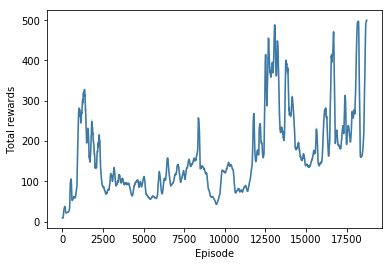

In [39]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

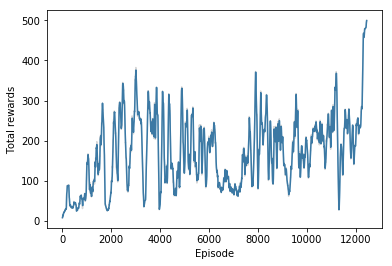

In [54]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

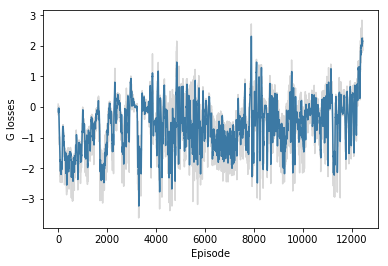

In [55]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

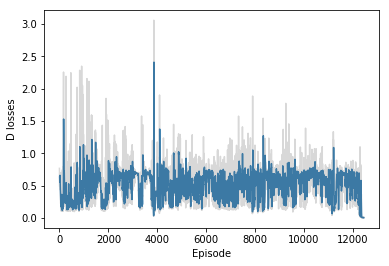

In [56]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 487.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.